In [1]:
#import line_profiler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

#### Euler

## Baseline Conditions

#### Set Constants and paramaters

In [2]:
#input params
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
M = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/m #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper
K = 5*10e-8

##reset df
df = None

#Input data from paper
df = pd.DataFrame({'Name': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'C', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1'], 
                   'Number': [1, 2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1],
                   'Diameter(µm)': [23.97, 19.17, 15.28, 12.08, 9.46, 7.32, 8, 11.51, 14.53, 17.79, 21.45, 25.70, 30.77],
                   'Length(µm)': [1267.6, 930.3, 543.6, 302.3, 161.2, 154.7, 243.9, 473.9, 272.3, 426.6, 632.5, 844.2, 936.3],
                   'Viscocity(mPAs)': [1.59, 1.50, 1.42, 1.34, 1.28, 1.23, 1.24, 1.33, 1.40, 1.48, 1.55, 1.62, 1.7],
                   'Pressure Drop(mmHg)': [6.93, 5.87, 4.02, 2.70, 1.82, 2.35, 2.62, 1.27, 0.61, 0.89, 1.31, 1.78, 2.01],
                   'Saturation': [0.94, 0.93, 0.92, 0.89, 0.84, 0.765, 0.665, 0.61, 0.5975, 0.5875, 0.5825, 0.5775, 0.5725],
                   'dS': [0.01, 0.01, 0.02, 0.04, 0.0625,0.0875, 0.0775, 0.03375, 0.01125, 0.0075, 0.005, 0.005, 0.005]
                  })


#### Calculate Flows and Vt

In [3]:
#Calculate resistances of each vessel
df['Resistance for U'] = 32 * df['Viscocity(mPAs)'] * df['Length(µm)'].div(df['Diameter(µm)']**2)
df['Resistance for Q'] = 128 * df['Viscocity(mPAs)'] * df['Length(µm)'].div(math.pi*(df['Diameter(µm)']**4))

#Alter resistances for C
#These are aross each pressure drop (explains the doubled resistance for the capillaries as in paralell so have half the flow each (flow is shared))
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U']*2
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q']*2

#Calculate flow and velocity in a single vessel
df['U in single(m/s????)'] = df['Pressure Drop(mmHg)'].div(df['Resistance for U'])
df['Q in single(m^3/s????)'] = df['Pressure Drop(mmHg)'].div(df['Resistance for Q'])

#Find change in saturdation from data on saturation curve
# S = pd.Series([])

#Calculate Vt CHANGE IN SATURATIO  YA SHIT HEAD
df['Vt'] = df['Q in single(m^3/s????)']*cHb*H*df['dS']/M

In [4]:
#all units were in mm so i played around with this equation from the paper
df['X-Area wall(mm^2?)'] = np.pi * ( 0.16*(df['Diameter(µm)'])**2 + 1.4*(df['Diameter(µm)']) + 14 )
df['wall thickness(µm)'] = ( -(df['Diameter(µm)']) + np.sqrt((df['Diameter(µm)'])**2 + (4*(df['X-Area wall(mm^2?)'])/np.pi)) ) / 2

#### Calculate partial pressure in tissue
Equations can be found on the week 1 or 2 notes from class. From steady state version of something on the paper

#### Pull out the baseline conditions

In [5]:
df_base = df
df_base

,Name,Number,Diameter(µm),Length(µm),Viscocity(mPAs),Pressure Drop(mmHg),Saturation,dS,Resistance for U,Resistance for Q,U in single(m/s????),Q in single(m^3/s????),Vt,X-Area wall(mm^2?),wall thickness(µm)
0,A1,1,23.97,1267.6,1.59,6.93,0.9400,0.01000,112.251787,0.248752,0.061736,27.859025,78005.271056,438.213672,4.841407
1,A2,2,19.17,930.3,1.50,5.87,0.9300,0.01000,121.512242,0.421004,0.048308,13.942870,39040.035790,313.016429,4.253658
2,A3,4,15.28,543.6,1.42,4.02,0.9200,0.02000,105.796442,0.576945,0.037997,6.967734,39019.312012,228.546291,3.810683
3,A4,8,12.08,302.3,1.34,2.70,0.8900,0.04000,88.829876,0.775060,0.030395,3.483601,39016.335895,170.463521,3.485850
4,A5,16,9.46,161.2,1.28,1.82,0.8400,0.06250,73.780690,1.049713,0.024668,1.733807,30341.627914,130.572935,3.265971
5,A6,32,7.32,154.7,1.23,2.35,0.7650,0.08750,113.637911,2.700295,0.020680,0.870275,21321.745183,103.110791,3.138293
6,C,64,8.00,243.9,1.24,2.62,0.6650,0.07750,302.436000,6.016773,0.008663,0.435449,9449.251212,111.338044,3.172168
7,V6,32,11.51,473.9,1.33,1.27,0.6100,0.03375,152.243122,1.463178,0.008342,0.867974,8202.351518,161.197683,3.433626
8,V5,16,14.53,272.3,1.40,0.61,0.5975,0.01125,57.782247,0.348476,0.010557,1.750477,5514.003939,214.009514,3.730525
9,V4,8,17.79,426.6,1.48,0.89,0.5875,0.00750,63.838202,0.256826,0.013941,3.465382,7277.302540,281.309064,4.092089


#### dropped by 50%

100%|██████████| 1001/1001 [00:00<00:00, 3700.96it/s]


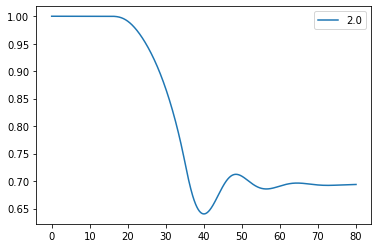

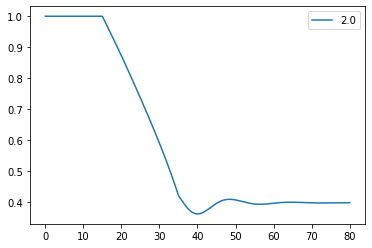

In [11]:
baselines = df_base[['Name','Number','Resistance for Q','Q in single(m^3/s????)','Vt','wall thickness(µm)','Diameter(µm)','Length(µm)']].rename(columns={"Q in single(m^3/s????)": "baseline Q"})

def total_R(baselines,phi):
    C_ = (baselines.loc[6,'Resistance for Q']/2)/phi**4
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

max_time = 80
no = 1001
t = pd.Series(np.linspace(0,max_time,no))

R_tot = pd.Series(np.zeros(len(t)))
Q_tot = pd.Series(np.zeros(len(t)))
Q_norm = pd.Series(np.ones(len(t)))
pressure_in = pd.Series(np.zeros(len(t)))

ratio_drop = 0.5
delay_pressure_drop = 15
time_for_drop = 20
drop_value = 60 - 34.18*ratio_drop

for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    elif t[i] <= delay_pressure_drop + time_for_drop:
        pressure_in[i] = 60 - ((t[i] - delay_pressure_drop)/time_for_drop)*(60-drop_value)
    else:
        pressure_in[i] = drop_value
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out



####Lets incorporate new model
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
#delay = 7.62
delay = 2.000

phi = pd.Series(np.ones(no))
phi_min = pd.Series(np.ones(no))
phi_min[0] = 1
dphidt = pd.Series(np.zeros(no))


dt = max_time/(no-1)
n=1

delay_number = round(delay/dt)

for i in tqdm(range(len(t))):
    R_tot[i] = total_R(baselines,phi[i])
    Q_tot[i] = pressure_difference[i]/R_tot[i]
    Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
    phi_min[i] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
        
    if i <= delay_number:
        dphidt[i] =  (1/optimised_value_tau)*( -         1        + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
    else:
        dphidt[i] =  (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
    
    phi[i+1] = dphidt[i]*dt + phi[i]
        
plt.plot(t,phi[0:len(t)],label=delay)
plt.legend()

plt.subplots()
plt.plot(t,Q_norm[0:len(t)],label=delay)
plt.legend()

combined = pd.DataFrame()
combined['t'] = t
combined['pressure_difference'] = pressure_difference
combined['phi'] = phi
combined['phi_min'] = phi_min
combined['dphidt'] = dphidt
combined['R_tot'] = R_tot
combined['Q_tot'] = Q_tot
combined['Q_norm'] = Q_norm


In [ ]:
combined.iloc[0:25]

In [ ]:
combined.iloc[30:80]

/Users/Debs/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Debs/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


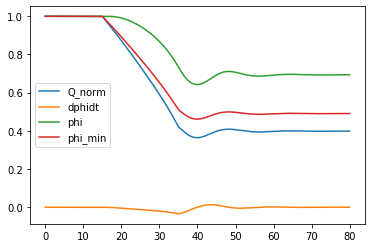

In [10]:
fig, ax = plt.subplots()
ax = plt.plot(t,Q_norm[0:len(t)], label='Q_norm')
ax = plt.plot(t,dphidt[0:len(t)], label='dphidt')
ax = plt.plot(t,phi[0:len(t)], label='phi')
ax = plt.plot(t,phi_min[0:len(t)], label='phi_min')

fig = plt.legend()

#### Testing dphidt

In [11]:
baselines = df_base[['Name','Number','Resistance for Q','Q in single(m^3/s????)','Vt','wall thickness(µm)','Diameter(µm)','Length(µm)']].rename(columns={"Q in single(m^3/s????)": "baseline Q"})

def total_R(baselines,phi):
    C_ = (baselines.loc[6,'Resistance for Q']/2)/phi**4
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

max_time = 40
no = 101
t = pd.Series(np.linspace(0,max_time,no))

R_tot = pd.Series(np.zeros(len(t)))
Q_tot = pd.Series(np.zeros(len(t)))
Q_norm = pd.Series(np.ones(len(t)))
pressure_in = pd.Series(np.zeros(len(t)))

ratio_drop = 0.01

for i in range(len(t)):
    if t[i] <= 25:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop

pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out


####Lets incorporate new model
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
delay = 7.62

phi = pd.Series(np.zeros(no))
phi_min = pd.Series(np.zeros(no))
dphidt = pd.Series(np.zeros(no))

phi[0] = 1
phi_min[0] = phi_min_baseline
Q_norm[0]=1

dt = max_time/(no-1)
n=1

delay_number = round(delay/dt)

(1/optimised_value_tau)*( -phi[66-delay_number] + Q_norm[66]*(1-phi_min[66]) + phi_min[66] )

# for i in range(len(t)):
#     if i >=delay_number: 
#         dphidt[i] = (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
#         R_tot[i] = total_R(baselines,phi[i])
#         Q_tot[i] = pressure_difference[i]/R_tot[i]
#         Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
#         phi[i+1] = dphidt[i]*dt + phi[i]
#         phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
#     else:
#         phi[i+1]=1
#         Q_norm[i+1]=1
#         phi_min[i+1] = phi_min_baseline
        
# plt.plot(t,phi[0:len(t)])

# combined = pd.DataFrame()
# combined['t'] = t
# combined['phi'] = phi
# combined['phi_min'] = phi_min
# combined['dphidt'] = dphidt
# combined['R_tot'] = R_tot
# combined['Q_tot'] = Q_tot
# combined['Q_norm'] = Q_norm

0.43612334801762115

In [12]:
baselines = df_base[['Name','Number','Resistance for Q','Q in single(m^3/s????)','Vt','wall thickness(µm)','Diameter(µm)','Length(µm)']].rename(columns={"Q in single(m^3/s????)": "baseline Q"})

def total_R(baselines,phi):
    C_ = (baselines.loc[6,'Resistance for Q']/2)/phi**4
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

max_time = 40
no = 101
t = pd.Series(np.linspace(0,max_time,no))

R_tot = pd.Series(np.zeros(len(t)))
Q_tot = pd.Series(np.zeros(len(t)))
Q_norm = pd.Series(np.zeros(len(t)))
pressure_in = pd.Series(np.zeros(len(t)))

ratio_drop = 0.5

for i in range(len(t)):
    if t[i] <= 15:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop

pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out


####Lets incorporate new model
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
delay = 7.62

phi = pd.Series(np.zeros(no))
phi_min = pd.Series(np.zeros(no))
dphidt = pd.Series(np.zeros(no))

phi[0] = 1
phi_min[0] = phi_min_baseline
Q_norm[0]=1

dt = max_time/(no-1)
n=1

delay_number = round(delay/dt)

dphidt[i] = (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )

# for i in range(len(t)):
#     if i >=delay_number: 
#         dphidt[i] = (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
#         R_tot[i] = total_R(baselines,phi[i])
#         Q_tot[i] = pressure_difference[i]/R_tot[i]
#         Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
#         phi[i+1] = dphidt[i]*dt + phi[i]
#         phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
#     else:
#         phi[i+1]=1
#         Q_norm[i+1]=1
#         phi_min[i+1] = phi_min_baseline
        
# plt.plot(t,phi[0:len(t)])

combined = pd.DataFrame()
combined['t'] = t
combined['phi'] = phi
combined['phi_min'] = phi_min
combined['dphidt'] = dphidt
combined['R_tot'] = R_tot
combined['Q_tot'] = Q_tot
combined['Q_norm'] = Q_norm

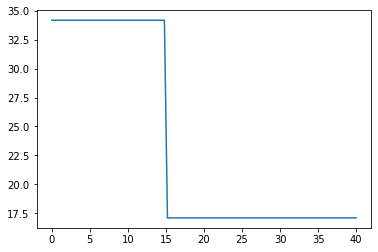

In [13]:
plt.plot(t,pressure_difference[0:len(t)])